# AMS 595 Group Project: Identifying Risk Factors for Major Depressive Disorder

### Abby Bindelglass, Jane Condon, Nicholas Tardugno, Sydney Walters-Diaz

## Data Preparation 

### Importing Necessary Libraries

In [309]:
# Insert libraries here
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
import lightgbm as lgb
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
import joblib

### Importing the Data

In [202]:
# Reading the dataset into python using pandas
df = pd.read_csv("mhcld_puf_2023.csv", low_memory=False)

ParserError: Error tokenizing data. C error: out of memory

In [ ]:
# Looking at the first few rows to ensure that the data has been imported correctly
df.head()

### Data Preprocessing

#### Mapping For Easier Readability

As shown above, the readability of the data is very poor, as is often seen with large survey data. To make the data easier to interpret and understand, we will map our variables to the values/explanations provided in the codebook. We will start with the target variable, "DEPRESSFLG". 

In [ ]:
# Target variable: depressive disorder variable map

depressflg_map = {
    1: "Depressive disorder reported",
    0: "Not reported"
}


We can also map the predictor variables into something that is easier to understand. We start with the co-occurring mental health disorder variables. Since the values have the same meaning for each of the variables, (i.e., 0 = disorder reported, 1 = disorder not reported), we can combine them into a single map. 

In [ ]:
# Predictor map: co-occurring mental health disorders map

disorder_flags = ["ANXIETYFLG", "ADHDFLG", "CONDUCTFLG", "DELIRDEMFLG", "BIPOLARFLG",
         "ODDFLG", "PDDFLG", "PERSONFLG", "SCHIZOFLG", "OTHERDISFLG",
         "TRAUSTREFLG", "ALCSUBFLG"]

binary_flag_map = {1: "Reported", 0: "Not reported"}

For our next predictor variable, substance use disorder, we have two variables that we may use:

* SAP (binary): Gives a value of 1 if substance use disorder present, 2 if substance use disorder not present, and 0 if the response to this survey question is missing.
* SUB (numeric): Gives a value of 1-13 indicating a client's substance use diagnosis during the reporting period (e.g., 9 = alcohol abuse, 10 = cocaine abuse), or a value of -9 for a missing/invalid diagnosis.

Since the category codes of these variables are different from those of the co-occurring mental health disorder variables and are NOT binary, we must create a separate map. We can use the SAP variable to construct a simple yes/no variable indicating whether or not a survey respondent has been diagnosed with any type of substance use disorder. If we want to look into this further, the SUB variable indicates WHICH substance use disorder an individual has been diagnosed with.

In [ ]:
# Predictor map: substance use map (SUB)

sub_use_map = {
    1: "Trauma/stressor disorder",
    2: "Anxiety disorder",
    3: "Attention deficit/hyperactivity disorder (ADHD)",
    4: "Conduct disorder",
    5: "Delirium/dementia disorder",
    6: "Bipolar disorder",
    7: "Depressive disorder",
    8: "Oppositional defiant disorder",
    9: "Pervasive developmental disorder",
    10: "Personality disorder",
    11: "Schizophrenia/psychotic disorder",
    12: "Alcohol or Substance Use Disorder",
    13: "Other disorder",
    -9: "Missing",
    -8: "Not applicable"
}


In [ ]:
# Predictor map: substance use map (SAP)
sap_map = {
    1: "Substance use problem reported",
    0: "No substance use problem reported",
    -9: "Missing",
    -8: "Not applicable"
}

# Applying to SAP column:
df["SAP_LABEL"] = df["SAP"].map(sap_map)

# Creating into a simple yes/no binary variable
df["HAS_SAP"] = df["SAP"].isin([1]).astype(int)

Some other useful predictor variables that we can map are age, sex, education status, marital status, residential status, veteran status, employment status, race/ethnicity, and geographic region (in the U.S.). 

In [ ]:
# Predictor map: age

age_map = {
    1: "0–11",
    2: "12–14",
    3: "15–17",
    4: "18–20",
    5: "21–24",
    6: "25–29",
    7: "30–34",
    8: "35–39",
    9: "40–44",
    10: "45–49",
    11: "50–54",
    12: "55–59",
    13: "60–64",
    14: "65+",
    -9: "Missing",
    -8: "Not applicable"
}


In [ ]:
# Predictor map: sex
sex_map = {
    1: "Male",
    2: "Female",
    -9: "Missing",
    -8: "Not applicable"
}


In [ ]:
# Predictor map: education level
educ_map = {
    1: "Special education",
    2: "8 years or less",
    3: "9–11 years",
    4: "12 years or GED",
    5: "13 years or more",
    -9: "Missing",
    -8: "Not applicable"
}


In [ ]:
# Predictor map: marital status
marstat_map = {
    1: "Never married",
    2: "Now married",
    3: "Separated",
    4: "Divorced or widowed",
    -9: "Missing",
    -8: "Not applicable"
}


In [ ]:
# Predictor map: residential status
livarag_map = {
    1: "Experiencing homelessness",
    2: "Private residence",
    3: "Other",
    -9: "Missing",
    -8: "Not applicable"
}


In [ ]:
# Predictor map: veteran status
veteran_map = {
    1: "Veteran",
    2: "Not a veteran",
    -9: "Missing",
    -8: "Not applicable"
}


In [ ]:
# Predictor map: employment status
employ_map = {
    1: "Full-time",
    2: "Part-time",
    3: "Employed (not differentiated)",
    4: "Unemployed",
    5: "Not in labor force",
    -9: "Missing",
    -8: "Not applicable"
}

In [ ]:
# Predictor map: ethnicity
ethnic_map = {
    1: "Hispanic or Latino",
    2: "Not Hispanic or Latino",
    -9: "Missing",
    -8: "Not applicable"
}

In [ ]:
# Predictor map: race
race_map = {
    1: "White",
    2: "Black or African American",
    3: "American Indian or Alaska Native",
    4: "Asian",
    5: "Native Hawaiian or Pacific Islander",
    6: "Multiracial",
    -9: "Missing",
    -8: "Not applicable"
}

In [ ]:
region_map = {
    1: "Northeast",
    2: "Midwest",
    3: "South",
    4: "West"
}

#### Creating a Pre-Processing Function

Next, we can create a pre-processing function that:
* Applies every mapping dictionary to the dataframe
* Creates binary flags (simple yes/no variable for appropriate variables)
* Handles missing values (using median/mode imputation)
* Returns a numeric dataframe for modeling, as well as a labeled dataframe that is easier to read/interpret

In [225]:
def preprocess_data(df):

    # Dealing with missing SAMHSA codes
    missing_codes = [-9, -8, -7, -6]
    df = df.replace(missing_codes, np.nan)

    # Preserving disorder flags as numeric
    for f in disorder_flags:
        if f in df.columns:
            df[f] = df[f].fillna(0).astype(int)

    # Preserving SUB and SAP as numeric predictors
    if "SUB" in df.columns:
        df["SUB"] = df["SUB"].fillna(0).astype(int)
    if "SAP" in df.columns:
        df["SAP"] = df["SAP"].fillna(0).astype(int)

    # Dropping unnecessary columns
    id_cols = ["CASEID", "STATEFIP"]
    df = df.drop(columns=[col for col in id_cols if col in df.columns])

    predictor_vars = [
        "AGE", "SEX", "EDUC", "MARSTAT", "LIVARAG",
        "VETERAN", "EMPLOY", "ETHNIC", "RACE",
        "SUB", "SAP", "REGION"
    ] + disorder_flags

    # Debugging: checking for missing predictor vars
    missing = [col for col in predictor_vars if col not in df.columns]
    if missing:
        print("Missing predictor columns:", missing)

    # Applying predictor selection
    df = df[[col for col in df.columns if col in predictor_vars or col == "DEPRESSFLG"]]

    # Applying mappings to the dataframe
    df["AGE_LABEL"] = df["AGE"].map(age_map)
    df["SEX_LABEL"]  = df["SEX"].map(sex_map)
    df["EDUC_LABEL"] = df["EDUC"].map(educ_map)
    df["MARSTAT_LABEL"] = df["MARSTAT"].map(marstat_map)
    df["LIVARAG_LABEL"] = df["LIVARAG"].map(livarag_map)
    df["VETERAN_LABEL"] = df["VETERAN"].map(veteran_map)
    df["EMPLOY_LABEL"] = df["EMPLOY"].map(employ_map)
    df["ETHNIC_LABEL"] = df["ETHNIC"].map(ethnic_map)
    df["RACE_LABEL"] = df["RACE"].map(race_map)

    df["REGION_LABEL"] = df["REGION"].map(region_map)

    df["SUB_LABEL"] = df["SUB"].map(sub_use_map)
    df["SAP_LABEL"] = df["SAP"].map(sap_map)
    df["DEPRESS_LABEL"] = df["DEPRESSFLG"].map(depressflg_map)

    for f in disorder_flags:
        df[f + "_LABEL"] = df[f].map(binary_flag_map)

    # Creating binary modeling flags (simple yes/no binary variables)
    df["HAS_SUBSTANCE_USE"] = (df["SUB"] == 12).astype(int)
    df["HAS_SAP"] = (df["SAP"] == 1).astype(int)
    df["MDD"] = (df["DEPRESSFLG"] == 1).astype(int)
    df["ANY_OTHER_MH_DISORDER"] = df[disorder_flags].fillna(0).max(axis=1)
    df["IS_VETERAN"] = (df["VETERAN"] == 1).astype(int)
    df["IS_HOMELESS"] = (df["LIVARAG"] == 1).astype(int)
    df["IS_MARRIED"] = (df["MARSTAT"] == 2).astype(int)

    # Using one-hot encoding for categorical variables
    categ_cols = [
        "AGE_LABEL", "SEX_LABEL", "EDUC_LABEL", "MARSTAT_LABEL",
        "LIVARAG_LABEL", "VETERAN_LABEL", "EMPLOY_LABEL",
        "ETHNIC_LABEL", "RACE_LABEL",
        "SUB_LABEL", "SAP_LABEL", "REGION_LABEL"
    ]

    model_df = pd.get_dummies(df.copy(), columns=categ_cols, drop_first=True)

    # Removing all columns containing "_LABEL" (including dummy-expanded ones)
    label_cols = [c for c in model_df.columns if "_LABEL" in c]
    model_df = model_df.drop(columns=label_cols, errors="ignore")

    # Handling missing values using imputation 
    num_cols = model_df.select_dtypes(include=["float64", "int64"]).columns
    cat_cols = model_df.select_dtypes(include=["object", "category"]).columns

    # For numerical variables: median imputation
    num_imputer = SimpleImputer(strategy="median")
    model_df[num_cols] = num_imputer.fit_transform(model_df[num_cols])

    # For categorical variables: mode imputation
    if len(cat_cols) > 0:
        cat_imputer = SimpleImputer(strategy="most_frequent")
        model_df[cat_cols] = cat_imputer.fit_transform(model_df[cat_cols])

    return df, model_df


In [227]:
# Calling the function
clean_df, model_df = preprocess_data(df)
model_df.isna().sum().sum() # Ensuring that missing values have been dealt with

0

#### Constructing Target Vector and Predictor Matrix

In [232]:
# Target variable
y = model_df["MDD"]

In [234]:
# Predictors matrix
X = model_df.drop(columns=["MDD", "DEPRESSFLG"], errors="ignore")

#### Splitting Data into Training, Validation and Test Set

In [237]:
model_df = model_df.reset_index(drop=True)

In [295]:
# Splitting into training and test set
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

In [297]:
# Splitting training set into training and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.20, random_state=42, stratify=y_train_full
)

## Exploratory Data Analysis

In [46]:
# Sydney's section

## Data Visualization

In [56]:
# Nick's section

## Logistic Regression

In [67]:
# Abby's section

## Predictive Modeling

### Random Forest Model

In [241]:
# Defining random forest model
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    max_features="sqrt",
    n_jobs=-1,
    class_weight="balanced",
    random_state=42
)


In [243]:
# Fitting random forest model
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15, n_estimators=200,
                       n_jobs=-1, random_state=42)

In [244]:
# Making predictions on y 
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:, 1]

In [245]:
print("RF AUC:", roc_auc_score(y_test, y_prob))
print(classification_report(y_test, y_pred))

RF AUC: 0.835669947110965
              precision    recall  f1-score   support

           0       0.91      0.71      0.80   1285911
           1       0.50      0.81      0.62    473000

    accuracy                           0.73   1758911
   macro avg       0.71      0.76      0.71   1758911
weighted avg       0.80      0.73      0.75   1758911



### Stochastic Gradient Descent (SGD) Model

Since we are unable to use a support vector machine model with data of this size, we implement a stochastic gradient descent model instead.

In [248]:
# Scaling the data and fitting the model
sgd = Pipeline([
    ("scaler", StandardScaler(with_mean=False)), 
    ("sgd", SGDClassifier(
        loss="log_loss",
        max_iter=1000,
        tol=1e-3,
        random_state=42
    ))
])

In [249]:
# Fitting the model
sgd.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler(with_mean=False)),
                ('sgd', SGDClassifier(loss='log_loss', random_state=42))])

In [250]:
# Making predictions on y
y_pred = sgd.predict(X_test)

In [251]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84   1285911
           1       0.57      0.35      0.43    473000

    accuracy                           0.75   1758911
   macro avg       0.68      0.63      0.64   1758911
weighted avg       0.73      0.75      0.73   1758911



### Light Gradient Boosting Machine (LIGHTGBM) Model

In [271]:
# Defining LIGHTBGM model
lgbm = lgb.LGBMClassifier(
    num_leaves=64,
    learning_rate=0.05,
    n_estimators=500,
    min_child_samples=50,
    subsample=0.8,
    colsample_bytree=0.8
)

In [273]:
# Fitting LIGHTBGM model
lgbm.fit(X_train, y_train)

C:\Users\janec\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\janec\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\janec\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\janec\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\janec\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreatePro

[LightGBM] [Info] Number of positive: 1418998, number of negative: 3857732
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.193201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 112
[LightGBM] [Info] Number of data points in the train set: 5276730, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.268916 -> initscore=-1.000128
[LightGBM] [Info] Start training from score -1.000128


LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, min_child_samples=50,
               n_estimators=500, num_leaves=64, subsample=0.8)

In [274]:
# Making predictions on y
y_pred = lgbm.predict(X_test)
y_prob = lgbm.predict_proba(X_test)[:,1]

In [275]:
print("AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

AUC: 0.8493751700193536

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87   1285911
           1       0.68      0.50      0.58    473000

    accuracy                           0.80   1758911
   macro avg       0.76      0.71      0.72   1758911
weighted avg       0.79      0.80      0.79   1758911



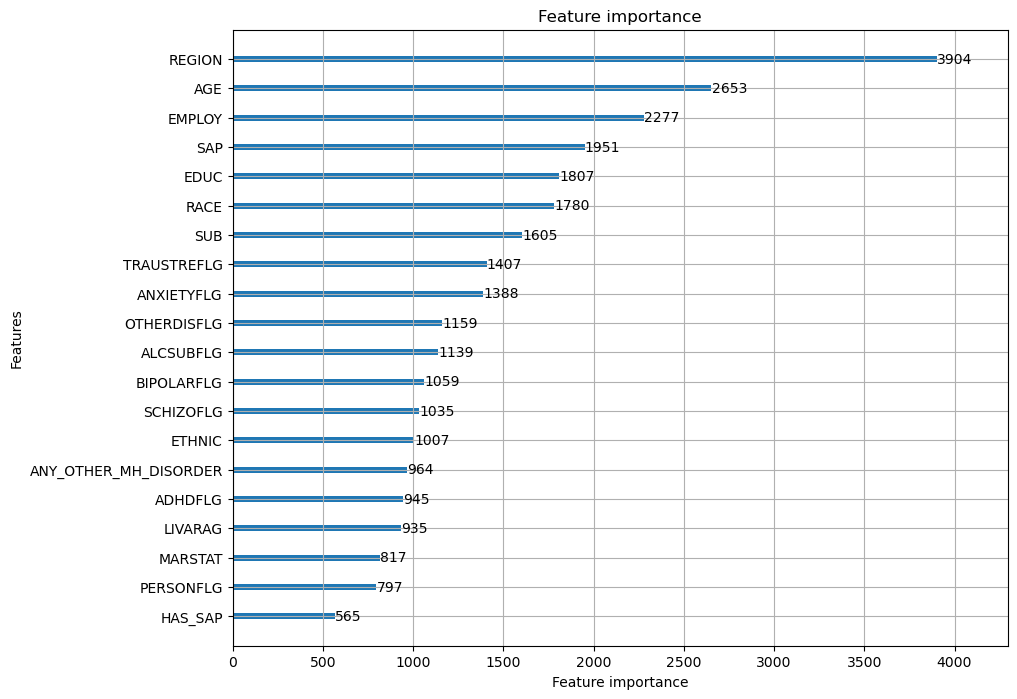

In [276]:
# Feature Importance
lgb.plot_importance(lgbm, max_num_features=20, figsize=(10, 8))
plt.show()

### CatBoost Model

In [299]:
# Defining CatBoost model
cat = CatBoostClassifier(
    iterations=2000,
    learning_rate=0.03,
    depth=6,
    od_type="Iter",
    od_wait=40,
    task_type="CPU",
    verbose=100
)


In [301]:
# Fitting CatBoost model
cat.fit(
    X_train, y_train,
    eval_set=(X_val, y_val),
    use_best_model=True
)


0:	learn: 0.6769341	test: 0.6770942	best: 0.6770942 (0)	total: 417ms	remaining: 13m 53s
100:	learn: 0.4567744	test: 0.4570695	best: 0.4570695 (100)	total: 27.3s	remaining: 8m 32s
200:	learn: 0.4417571	test: 0.4421576	best: 0.4421576 (200)	total: 51.7s	remaining: 7m 43s
300:	learn: 0.4361152	test: 0.4365285	best: 0.4365285 (300)	total: 1m 15s	remaining: 7m 4s
400:	learn: 0.4321004	test: 0.4325332	best: 0.4325332 (400)	total: 1m 38s	remaining: 6m 33s
500:	learn: 0.4295342	test: 0.4299651	best: 0.4299651 (500)	total: 2m 2s	remaining: 6m 5s
600:	learn: 0.4275060	test: 0.4279479	best: 0.4279479 (600)	total: 2m 25s	remaining: 5m 39s
700:	learn: 0.4255967	test: 0.4260498	best: 0.4260498 (700)	total: 2m 49s	remaining: 5m 13s
800:	learn: 0.4240489	test: 0.4245080	best: 0.4245080 (800)	total: 3m 13s	remaining: 4m 49s
900:	learn: 0.4228366	test: 0.4233054	best: 0.4233054 (900)	total: 3m 36s	remaining: 4m 24s
1000:	learn: 0.4215286	test: 0.4219993	best: 0.4219993 (1000)	total: 4m	remaining: 4m
110

In [302]:
# Making predictions on y
y_pred = cat.predict(X_test)
y_prob = cat.predict_proba(X_test)[:, 1]

In [303]:
print("AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

AUC: 0.8472771892330605

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87   1028729
           1       0.68      0.50      0.58    378400

    accuracy                           0.80   1407129
   macro avg       0.75      0.71      0.72   1407129
weighted avg       0.79      0.80      0.79   1407129



In [304]:
# Feature importance
cat.get_feature_importance(prettified=True)

,Feature Id,Importances
0,ANXIETYFLG,16.719575
1,TRAUSTREFLG,12.894044
2,BIPOLARFLG,9.354021
3,OTHERDISFLG,8.932102
4,ADHDFLG,8.438186
5,ANY_OTHER_MH_DISORDER,7.262891
6,AGE,6.918724
7,SCHIZOFLG,5.516353
8,REGION,4.860434
9,SAP,3.154797


### Saving Models

In [312]:
# Saving models
joblib.dump(rf, "random_forest_model.pkl")
joblib.dump(sgd, "sgd_model.pkl")
joblib.dump(lgbm, "lightgbm_model.pkl")

['lightgbm_model.pkl']

In [314]:
# Loading models
rf = joblib.load("random_forest_model.pkl")
sgd = joblib.load("sgd_model.pkl")
lgbm = joblib.load("lightgbm_model.pkl")

In [320]:
# Saving CatBoost model
cat.save_model("catboost_model.cbm")

In [322]:
# Loading CatBoost model
cat = CatBoostClassifier()
cat.load_model("catboost_model.cbm")

## Model Evaluation

### Performance Metrics: Accuracy, F1, AUC, Recall, Precision

### Confusion Matrix

### ROC Curve

### Calibration Curve

### Feature Importance